# Outlier pruning
>#### Discussion from Hogg, Bovy, & Lang 2010, "[Fitting a model to data](https://arxiv.org/abs/1008.4686)"
>#### Very readable article on the subject, using the Hubble Tension as an example: Press 1997, "[Understanding data better with Bayesian and global statistical methods](https://arxiv.org/pdf/astro-ph/9604126.pdf)"
>#### Code based on https://github.com/nadanai263/fittingmodeltodata/tree/master (MIT license)

# Preamble

In [6]:
%matplotlib inline
import numpy as np # 1.13.3
import matplotlib.pyplot as plt #2.1.1
import pandas as pd # 0.22.0
try:
  import emcee # 2.2.1
except:
  !pip install emcee
  import emcee
try:
  import corner # 2.0.1
except:
  !pip install corner
  import corner
import seaborn as sns # 0.8.1
import requests
from importlib import util
import sys

def import_from_url(url, module_name):
    # Fetch the script content from the URL
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"Failed to download the code from {url}")

    # Load the script content into a new module
    spec = util.spec_from_loader(module_name, loader=None)
    new_module = util.module_from_spec(spec)
    exec(response.text, new_module.__dict__)
    sys.modules[module_name] = new_module

url = 'https://raw.githubusercontent.com/nadanai263/fittingmodeltodata/master/plot_helper.py'
module_name = 'plot_helper'
import_from_url(url, module_name)
import plot_helper as plot_helper
from IPython.display import HTML, display

# Introduction

>#### Hogg et al. (2010) discuss various techniques to fit models to data. Their full dataset contains a handful of points that are severe outliers. They also discuss how to identify and account for outliers when computing the fit.
>#### Most standard methods of model fitting produce skewed results when they are used to fit data with outliers.
>#### Hogg et al. (2010) suggest the Gaussian Mixture Model (GMM) which, when combined with MCMC sampling, is robust against outliers.

>#### Let's view the data. **The first four points are outliers**:

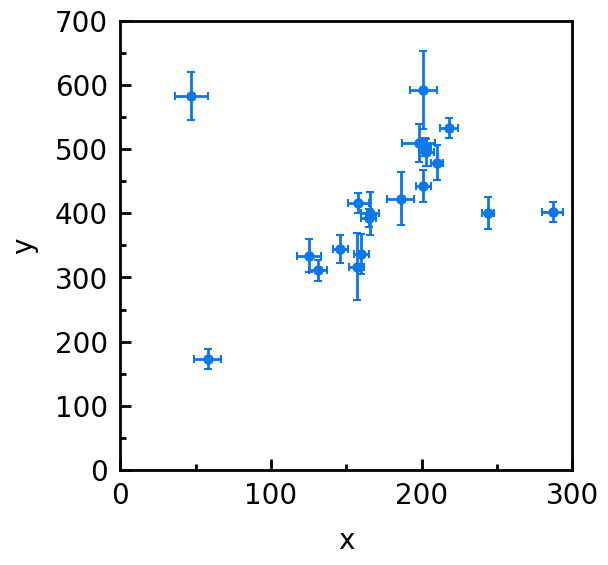

0    201
1    244
2     47
3    287
Name: x, dtype: int64 0    592
1    401
2    583
3    402
Name: y, dtype: int64


In [7]:
url = 'https://raw.githubusercontent.com/nadanai263/fittingmodeltodata/master/data.csv'
df = pd.read_csv(url, delimiter=',')
plot_helper.plot1(df['x'], df['y'], df['sx'], df['sy'], [0,300], [0,700])
print(df['x'][:4], df['y'][:4])

# 1. Linear model for the entire dataset
#### Let's first assume that a linear model perfectly describes all our observations except for Gaussian measurement noise. That is,
>#### $y_i = m x_i + b + \epsilon$, with $\epsilon\sim\mathscr{N}(0, \sigma_i^2)$
#### The corresponding likelihood is then
>#### $\mathscr{L} = \displaystyle\prod\limits_{i=1}^N\displaystyle{1\over\sqrt{2\pi\sigma_i^2}}\exp{\Bigg[-\displaystyle{1\over 2}{\Big(\displaystyle{y_i-mx_i-b\over\sigma_i}\Big)^2}\Bigg]}$

#### The model only has two parameters, the slope and the intercept. We pick uniform priors for both, over a reasonable range of values.

# Code
#### The basic components of the code are the same as for every MCMC script. We include functions to compute the **likelihood**, **prior**, and **posterior** probabilities. We also include functions that allow us to inspect the MCMC results -- we **plot the trace** of the samples, we **compute the autocorrelation time** and use it to check whether the traces of all the parameters converged, and we visualise parameter covariances using a **corner plot**. Finally, we plot posterior samples onto the data to inspect the **quality of the fits**, and print out the resulting **percentiles** for each parameter.

In [8]:
def lnlike(theta,x,y,yerr):
    b, m =theta
    return -0.5 * np.sum(((y - m * x - b) / yerr)**2 + np.log(2 * np.pi * yerr**2))

def lnprior(theta):
    b, m = theta

    if not (-100 < b < 150 and 0 < m < 5) :
        return -np.inf
    return 0

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

def plot_trace(labels, samples):
  fig, axes = plt.subplots(len(labels), figsize=(10, len(labels)), sharex=True)
  for i in range(len(labels)):
      ax = axes[i]
      ax.plot(samples[:, i], "k", alpha=0.3)
      ax.set_xlim(0, samples.shape[0])#len(samples))
      ax.set_ylabel(labels[i])
      ax.yaxis.set_label_coords(-0.1, 0.5)

  axes[-1].set_xlabel("step number");
  plt.show()

def autocorr_check(sampler):
  tau = sampler.get_autocorr_time()
  print(f"Autocorrelation time estimated in three ways: {tau}")
  samples = sampler.get_chain()
  if samples.shape[0] < tau[0] * 50:
    print("Caution: Number of samples in chain fewer than 50 times the autocorrelation time!")
  else:
    print("Number of samples in chain adequate for autocorrelation time estimate!")

def print_percentiles(samples, labels):
  mcmc = np.percentile(samples, [16, 50, 84], axis=0)
  print((mcmc[2, 1] - mcmc[0, 1]) / mcmc[1, 1], (mcmc[1, 1]-0.5)/mcmc[1, 1])
  for i in range(samples.shape[1]):
      q = np.diff(mcmc[:, i])
      txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
      txt = txt.format(mcmc[1, i], q[0], q[1], labels[i])
      display((txt))

def do_mcmc(x, y, yerr, labels=["$b$", "$m$"], initial=[34.0, 2.24], outfile='inliers'):
  ndim, nwalkers, threads, iterations, tburn = len(labels), 100, 8, 5000, 2500
  pos = [np.array([init * (1 + 0.05 * np.random.randn()) for init in initial]) for i in range(nwalkers)]

  sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, a=2, args=(x, y, yerr), threads=threads)
  final_state, log_prob, state = sampler.run_mcmc(pos, iterations, progress=True)

  samples = sampler.chain[:, :, :].reshape((-1, ndim)) # shape = (nsteps, ndim)
  plot_trace([l.replace('$', '') for l in labels], samples)

  df0 = pd.DataFrame(samples)
  df0.to_csv(path_or_buf='samplesout_' + outfile + '.csv', sep=',')
  samplesnoburn = plot_helper.readsamples('samplesout_' + outfile + '.csv',
                                          tburn, nwalkers, iterations)

  autocorr_check(sampler)
  print_percentiles(samplesnoburn, labels)

  fig = corner.corner(samplesnoburn, labels=labels, truths=None,
                      quantiles=[0.16, 0.5, 0.84], show_titles=True,
                      title_fmt='.2e', title_kwargs={"fontsize": 10},
                      verbose=False)

  f, axs = plt.subplots()
  axs.errorbar(x, y, yerr=yerr, fmt='o', zorder=100)
  xx = np.linspace(0, 300, 100)
  k = np.random.choice(samplesnoburn.shape[0], 100)
  for kk in k:
    axs.plot(xx, samplesnoburn[kk, 0] + samplesnoburn[kk, 1] * xx, 'k-', alpha=0.2)
  axs.set_xlim(0, 300)
  axs.set_ylim(0, 700)

#### The first call to the code is only with the inlier points to get an idea of the "true relationship".

100%|██████████| 5000/5000 [00:12<00:00, 402.08it/s]


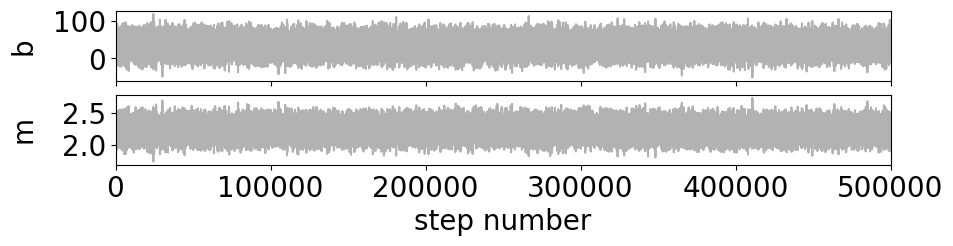

Autocorrelation time estimated in three ways: [29.63578266 30.16617736]
Number of samples in chain adequate for autocorrelation time estimate!
0.09452841642257379 0.7769795216429152


'\\mathrm{$b$} = 33.645_{-17.850}^{18.082}'

'\\mathrm{$m$} = 2.242_{-0.106}^{0.106}'

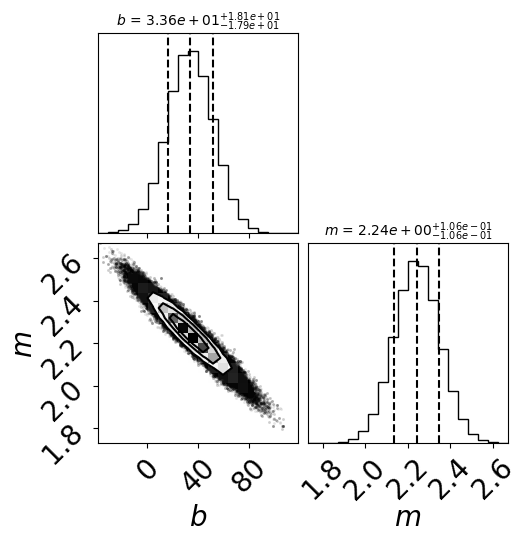

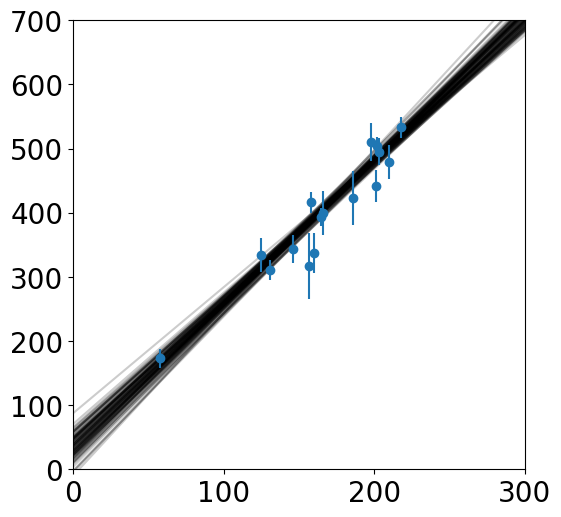

In [9]:
# Only select the inliers
x = df['x'][4:].values
y = df['y'][4:].values
yerr = df['sy'][4:].values

do_mcmc(x, y, yerr, outfile='inliers')

#### The second call to the code is with the entire dataset, which will produce fits biased by the outliers.

100%|██████████| 5000/5000 [00:11<00:00, 433.95it/s]


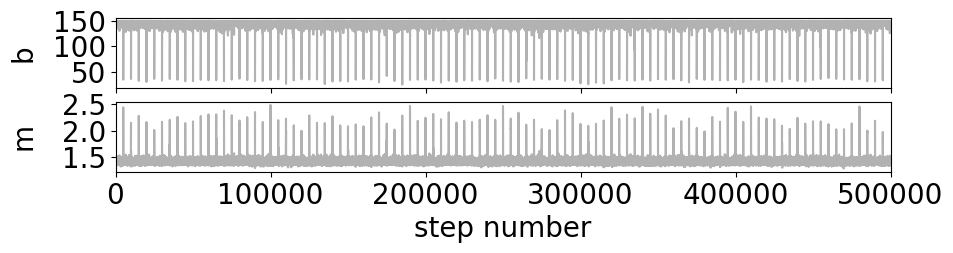

Autocorrelation time estimated in three ways: [44.70804113 39.35366517]
Number of samples in chain adequate for autocorrelation time estimate!
0.04000953935975346 0.646221658043346


'\\mathrm{$b$} = 147.787_{-3.475}^{1.648}'

'\\mathrm{$m$} = 1.413_{-0.027}^{0.029}'

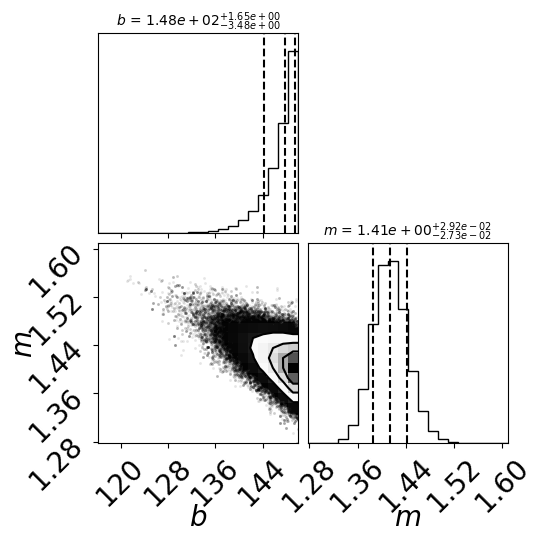

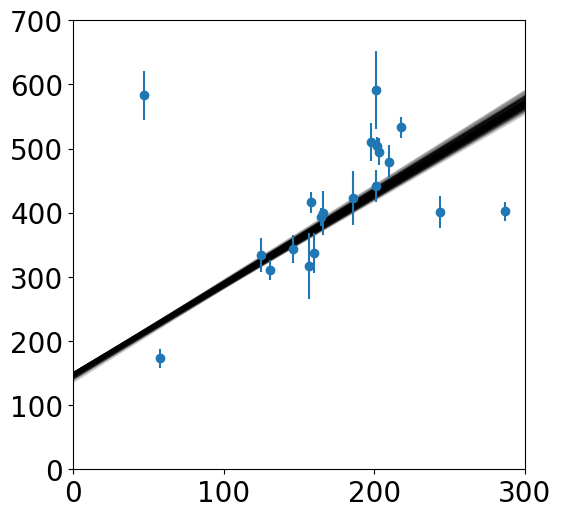

In [10]:
# Fit the entire dataset with outliers
x = df['x'].values
y = df['y'].values
yerr = df['sy'].values

do_mcmc(x, y, yerr, outfile='all')

# Sigma clipping (a.k.a. "tail trimming")
### What is it?
(1) perform a fit using some model (2) identify points that are not well fit by the model as "outliers" (3) remove them and repeat the fit with the pruned dataset.
Examples:
1) Model: source brightness is not variable, and only shows changes due to measurement uncertainties.
Procedure: Compute the mean and standard deviation of the source brightness, remove all points that are more than 2-sigma away from the mean. If the variation in brightness around the mean value is [Gaussian] random, then the probability of observing brightness outside the 2-sigma range is 5%.
However, without knowing the nature of the source, this is a difficult decision to make. For instance, a star might have recently undergone an brief eruptive event which produced a very bright point on its light curve. OR this bright point could be emission from a nearby source or something else altogether.
2) Model: source luminosity increases linearly with infrared colour.
Procedure: Compute the $\chi^2$ of the best-fit line. Compute the contribution of each point in the sample to this $\chi^2$. If the contribution is greater than a threshold value, reject this point.

### Why is it good?
Simple and fast procedure if the overall dataset is good quality.
### Why is it bad?
Answer depends on the threshold selected. If the threshold is too high, very few points will be rejected. If it is too low, in principle you can reject all but two points! Not objective.

How do you define a "good" result?
-- "least scatter around the model"? The fit can be improved by removing more points! How many is too many?
-- "it fits as many points as possible"? This will result in a large $\chi^2$.

The $\chi^2$ should be penalised when the sample size decreases (e.g., Bayesian Information Criterion), but this isn't done.

The "outlier" value(s) might be consistent with measurement uncertainties or the intrinsic variation of the system under consideration! If these are not known, you can't really perform sigma clipping!

### Why is the mixture-model method better?
It is objective, justifiable, and reproducible.
Defines a likelihood which, when minimised in the usual fashion, automatically accounting for the finite probability that a given point is an outlier. No subjective decision needs to be made by the user.

If a candidate outlier has a small uncertainty, a non-robust fit will be "pulled" towards this outlying value. In the mixture model, however, a small uncertainty will increase certainty that this point is an outlier!

#2. Gaussian Mixture Model: Linear model for "inliers" + constant model for "outliers"
#### We will split our data into two subsamples: one consisting of the data that is truly representative of the source, and another which contains values that are the result of processes unrelated to the source. The model for the inliers will be the same as before. For the outliers, we assume a constant model with Gaussian uncertainties.
#### We will assume that each data point **has the same probability** $P_b$ of being "bad". Without any other information about our dataset, this is the least informative prior we can select.
#### The corresponding likelihood is then
>#### $\mathscr{L} \propto \displaystyle\prod\limits_{i=1}^N\Bigg\{\displaystyle{1-P_b\over\sqrt{2\pi\sigma_i^2}}\exp{\Bigg[-\displaystyle{1\over2}\displaystyle{\Big(\displaystyle{y_i-mx_i-b\over \sigma_i}\Big)^2}\Bigg]} + \displaystyle{P_b\over\sqrt{2\pi(V_b + \sigma_i^2)}}\exp{\Bigg[-\displaystyle{1\over2}\displaystyle{(y_i-Y_b)^2\over V_b + \sigma_i^2}\Bigg]}\Bigg\}$

#### We now have three additional parameters related to the outlier likelihood: the prior probability $P_b$ that each point is an outlier, the mean value $Y_b$ that each outlier intrinsically possesses, and the variance $V_b$ due to some noise-generating process that makes the outlier value different from this mean.

#### We only need to modify the `lnlike` and `lnprior` modules in the code.
The log-likelihood is a sum of the log-likelihoods of the inlier and outlier models.
We use uniform priors for $P_b$ and $Y_b$, and a uniform prior for $\log{V_b}$.

100%|██████████| 5000/5000 [00:20<00:00, 246.23it/s]


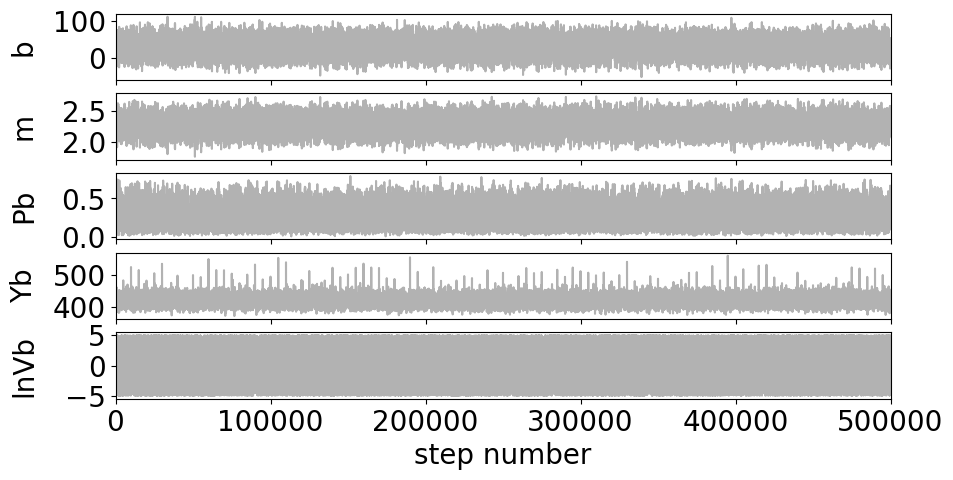

Autocorrelation time estimated in three ways: [66.19387292 66.61763285 61.77166828 59.44457546 76.8105427 ]
Number of samples in chain adequate for autocorrelation time estimate!
0.09556851112052352 0.7805211450528216


'\\mathrm{$b$} = 28.551_{-18.190}^{18.386}'

'\\mathrm{$m$} = 2.278_{-0.109}^{0.108}'

'\\mathrm{$Pb$} = 0.268_{-0.103}^{0.122}'

'\\mathrm{$Yb$} = 420.271_{-11.395}^{11.977}'

'\\mathrm{$lnVb$} = 0.701_{-3.847}^{3.405}'

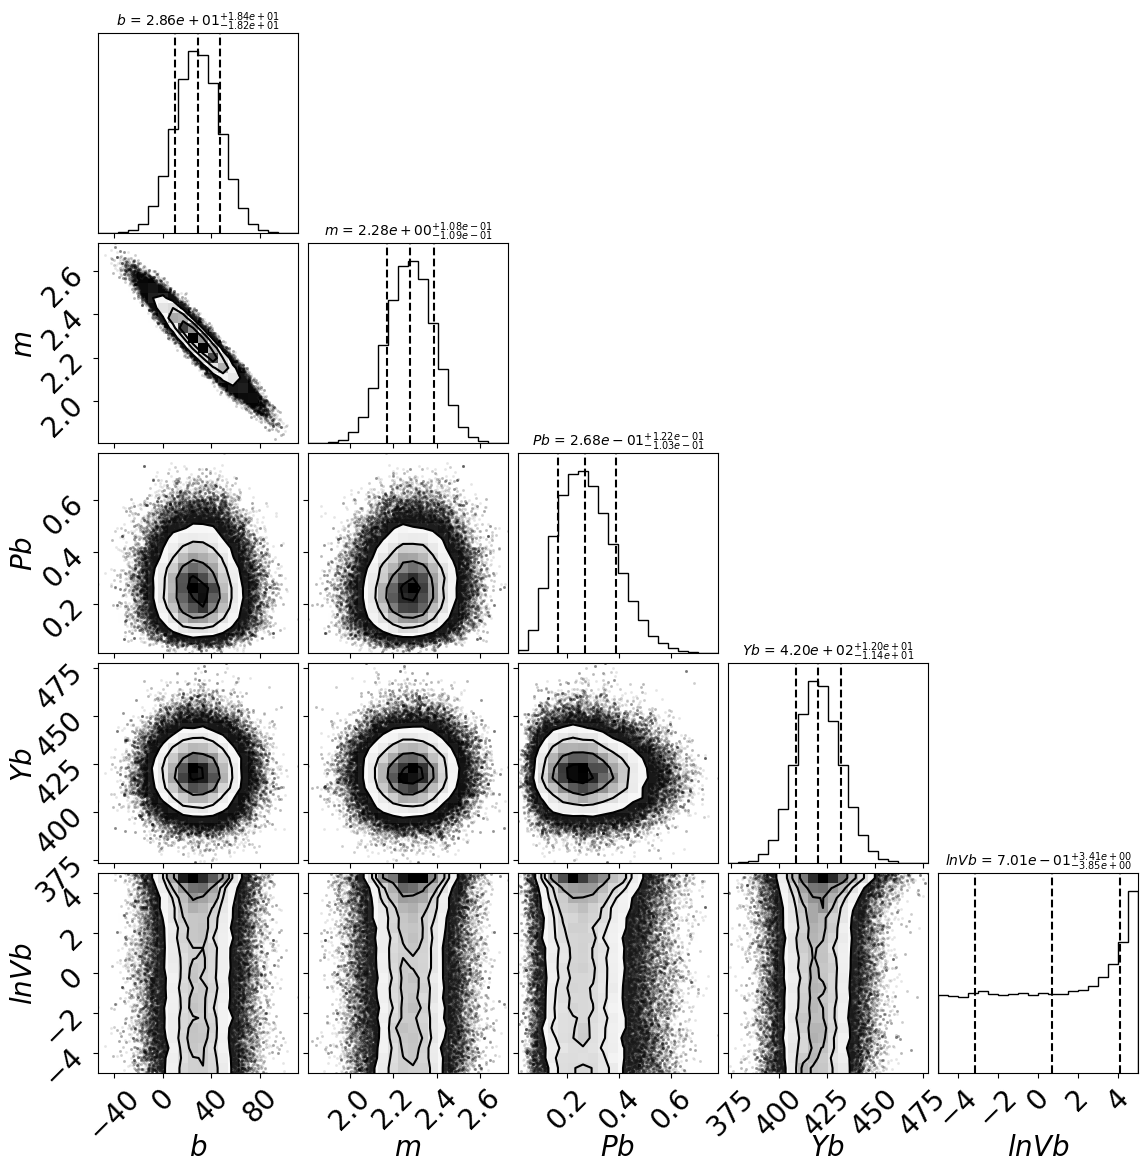

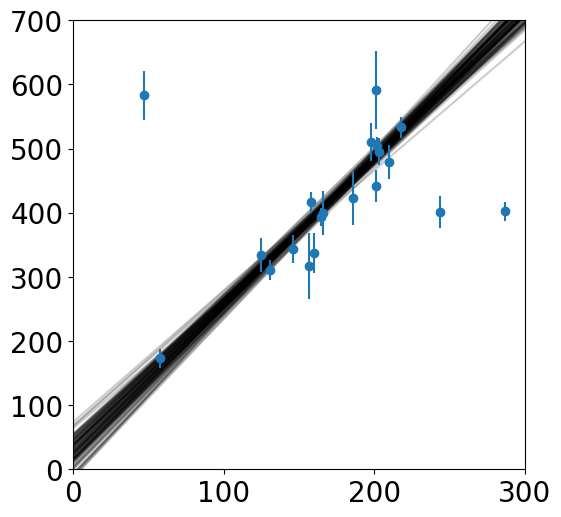

In [11]:
def lnlike(theta, x, y, yerr):
    b, m, Pb, Yb, lnVb = theta
    Vb = np.exp(lnVb)
    like = np.prod((1-Pb) / (np.sqrt(2 * np.pi * yerr**2)) * np.exp(-(y - m * x - b)**2 / (2*yerr**2)) +
                   Pb / (np.sqrt(2 * np.pi * (Vb+yerr**2))) * np.exp(-(y - Yb)**2 / (2*(Vb + yerr**2))))
    return np.log(like)

def lnprior(theta):
    b, m, Pb, Yb, lnVb = theta

    if not (-100 < b < 150 and 0 < m <5 and
            0 < Pb < 1 and 0 < Yb < 1000 and -5 < lnVb < 5) :
        return -np.inf
    return 0

# As before, we will use the entire dataset
do_mcmc(x, y, yerr, labels=["$b$","$m$","$Pb$","$Yb$","$lnVb$"],
        initial=[34.0, 2.24, 0.5, 500, 1.0], outfile='mixture')

#### While the $P_b$ and $Y_b$ parameters are well constrained, $V_b$ is not (the traces shows that it spans the entire range of the prior values). Despite this, the slope and intercept are quite well constrained, and for this dataset they are close to the values obtained if outliers are ignored. This demonstrates that the method is robust!
#### Also note that probability that a given point is an outlier is about 20% for this dataset.

# Moral of the story:
#### MCMC allows you to incorporate all your lack of knowledge into the model in the form of nuisance parameters. The details of the parameters are relatively unimportant, as the final results for your relevant parameters are marginalised over the nuisance ones. However, including these parameters provides a stronger basis for the likelihood chosen to model the data.

#### Outlier rejection and robost fitting can also be treated as a problem with nuisance parameters. In this case, we assumed that the "inlier" population is overlaid on a background population of points such that the data values of the background points are represented by a constant with Gaussian noise. We then quantify the likelihood that, given some data, they are either part of the background or the data of interest.

# Where I'm planning to apply the outlier pruning method

#### SED fitting, light curve fitting.
#### I'll report back soon!